# Team Update 6

For this assignment, you'll be looking at the current state of your design process and evaluating the effect of potential changes to your design.

In [1]:
import os
from pathlib import Path

import sys
ISST_DIR = str(Path(os.getcwd()).parent.parent.parent)
sys.path.append(ISST_DIR)

import numpy as np
import arviz as az
import pymc as pm

import matplotlib.pyplot as plt

import ISST

# Evaluating Utility

In Team Update 5, you implemented your Impact Tables, and looked at the effects of individual risks on the parameters that those Impact Tables quantified. Now we'll start to work on actually using the results of the analysis for decision making in our design process. To do this, we'll need to revisit utility functions.

In Team Update 5, you plotted the discrete and logistic utility functions defined by your Impact Tables, but you also have the option of defining your own utility functions.

For instance, if your impact parameters is some "error" from a nominal value, e.g. you're targeting a particular orbital altitude, you could define an Impact table that defines the utility function in terms the deviation from the nominal value: 

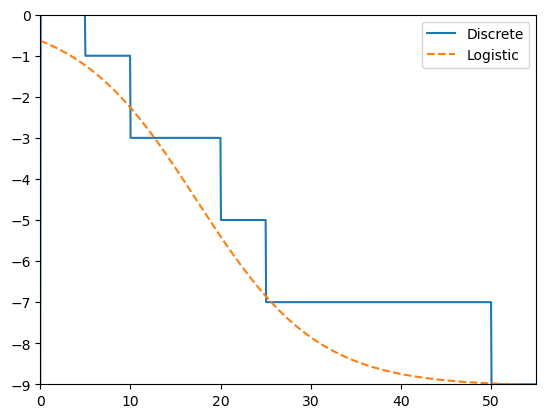

In [2]:
Altitude_Impact_Table = ISST.ImpactTable(name='Orbital Altitude Error',
                                         units='km',
                                         utility_breakpoints=[0, 5., 10., 20., 25., 50.],
                                         utilities=[0., -1., -3., -5., -7., -9.],
                                         utility_names=['0 km Error',
                                                        '5 km Error',
                                                        '10 km Error',
                                                        '20 km Error',
                                                        '25 km Error',
                                                        '50 km Error']
)

Altitude_Impact_Table.plot_utilities()

Let's set up a basic design system incorporating this as a technical parameter, using the same cost and schedule tables as in the Example System Setup notebook, and with a risk of navigation system error. Since we're using just the one risk, we'll set its parameters manually instead of reading them in from a file:

In [3]:
Nav_Risk = ISST.Risk(name='Navigation Risk',
                     baseline_likelihood = 0.9,
                     
                     #Schedule Risk Parameters
                     schedule_risk_minimum_value=1.,
                     schedule_risk_maximum_value=18.,
                     schedule_risk_most_likely_value=3., 
                                                      
                     # Cost Risk Parameterers         
                     cost_risk_minimum_value=np.log10(100000),
                     cost_risk_maximum_value=np.log10(2000000), 
                     cost_risk_most_likely_value=np.log10(500000),
                                                      
                     # Technical Risk Parameters      
                     technical_risk_minimum_values=[-50.],
                     technical_risk_maximum_values=[200.],
                     technical_risk_most_likely_values=[0.]
                     )

Log_Cost_Risk_Table = ISST.ImpactTable(name='LogCost',
                                       units='logEUR',
                                       utility_breakpoints=[5., 6., 6.69897, 7., 7.69897, 8.],
                                       utilities=[-1., -2., -4., -6., -8., -10.],
                                       utility_names=['100k Euros',
                                                      '1M Euros',
                                                      '5M Euros',
                                                      '10M Euros',
                                                      '50M Euros',
                                                      '100M Euros'])

Schedule_Risk_Table = ISST.ImpactTable(name='Schedule',
                                       units='months',
                                       utility_breakpoints=[0., 3., 6., 12., 24., 36., 60., 120.],
                                       utilities=[0., -0.5, -1., -2., -3., -5., -7., -10.],
                                       utility_names=['0 months',
                                                      '3 months',
                                                      '6 months',
                                                      '12 months',
                                                      '24 months',
                                                      '36 months',
                                                      '60 months',
                                                      '120 months'])

Example_Design_System = ISST.DesignSystem(name='Example_Design_System',
                                          model_context=pm.Model(),
                                          risks=[Nav_Risk],
                                          schedule_risk_table = Schedule_Risk_Table,
                                          cost_risk_table = Log_Cost_Risk_Table,
                                          technical_risk_tables = [Altitude_Impact_Table])

results = Example_Design_System.analyze_system()
az.plot_posterior(results,
                  var_names=['Total Orbital Altitude Error Utility Impact'])

ValueError: order must be one of 'C', 'F', 'A', or 'K' (got 'Total Cost Utility Impact')

This works well enough, but in this example, the direction of the error really affects the actual utility impact of the error. The Lunar Reconnaissance Orbiter has an orbital perigee (technically periselene for the moon) of 20 km, so being 20 km *below* your nominal altitude is a much worse outcome than being 20 km *above* your nominal altitude. Our utility function probably looks more like an assymetric bell curve, which goes to -10 much faster on the negative side of the curve than it does on the positive side of the curve:

In [ ]:
def bell_curve_utility(impact, max_utility=10, center=0., decay_rate = 1.):
    return max_utility * np.exp(-(impact-center)**2/(1/decay_rate))

def orbital_error_utility(altitude_error):
    return ((altitude_error < 0) * bell_curve_utility(altitude_error, decay_rate = 0.01) +
            (altitude_error >= 0) * bell_curve_utility(altitude_error, decay_rate = 0.0001))

In the above cell, `(altitude_error < 0)` returns `True (==1)` if our error is negative, and `False (==0)` otherwise, vice-versa for `(altitude_error >= 0)`. This way, only the version of bell_curve_utility that has the decay_rate appropriate to that side of the curve is used without having to use an if statement. Let's plot it over a range of potential errors to see what it looks like:

In [ ]:
error_range = np.linspace(-50., 200., 1000)
plt.plot(error_range, orbital_error_utility(error_range))
plt.xlabel('Altitude Error (km)')
plt.ylabel('Utility')
plt.show()